In [209]:
Threads.nthreads()

8

# Radar System Simulation

In [9]:
using Plots
using DSP
using FFTW
using Peaks
using Statistics
using GradDescent

In [2]:
include("radarsim.jl")
using .radarsim;

### System Constants

In [212]:
samp_rate = 100e6  #hz
prf = 100 #Hz
duty_factor = .15; #.05
β = 1e6; #Pulse Bandwidth
repetitions = 128;
fc = 900_000_000; #Hz

Gt = 40; #dB
Gr = 45; #dB
system_loss = 6; #dB
coefficients = [2,560,1485];

targets = [Target(560_094, 0)]
num_targets = length(targets);
target_dist = 560_094;

first_return_samples_num = floor(Int, samp_rate*((target_dist*2)/c)*1.2);

In [213]:
τ = duty_factor * (1/prf);
λ = (1/fc) * c;

### Min and Max theoretical range

In [214]:

println("Maximum Range (km): ", (1/prf * c / 2) / 1000)
println("Minimum Range (km): ", (τ * c / 2) / 1000)


Maximum Range (km): 1498.96229
Minimum Range (km): 224.8443435


### Simulation

In [215]:
t, pulse_train = gen_pulse_train(repetitions, samp_rate, prf, τ, β, envelope_type="Rectangular", pulse_type="NOrderPoly", coefficients=coefficients);

In [216]:
rx_pulse_train, noise = sim_return(samp_rate, pulse_train, targets, fc=fc, system_loss=system_loss, Gt=Gt, Gr=Gr, SNR=20);

#### Spectrogram

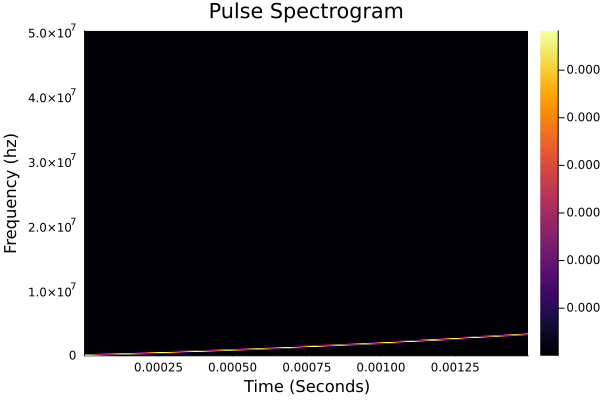

In [217]:
fft_size = 512;
spec = spectrogram(pulse_train[begin:round(Int, τ*samp_rate)], fft_size; fs=samp_rate); #+ pulse_train

heatmap(spec.time, LinRange(0,samp_rate/2, round(Int, fft_size/2)), spec.power[begin:round(Int, fft_size/2) , :], xguide="Time (Seconds)", yguide="Frequency (hz)", title="Pulse Spectrogram")

#### Pulse Compression

In [218]:
null, p = single_pulse(samp_rate, prf, τ, β, envelope_type="Rectangular", pulse_type="NOrderPoly", coefficients=coefficients);
p = p[begin:round(Int, τ*samp_rate)];
pulse_compression = conv(rx_pulse_train, conj(reverse(p)));
pulse_compression = pulse_compression[length(p)-1:length(rx_pulse_train)-(length(p)-1)];

In [219]:
sigPower = abs.(pulse_compression[begin:first_return_samples_num]);
sigPowerdB = 10*log10.(real.(pulse_compression[begin:first_return_samples_num]).^2 .+ imag.(pulse_compression[begin:first_return_samples_num]).^2);
plot(t[begin:first_return_samples_num], sigPower, xguide="Time (s)", yguide="Magnitude", title="Pulse Compressed Signal")

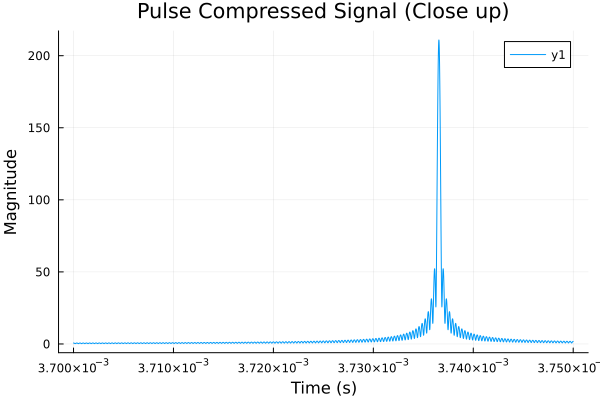

In [220]:
plot(t[370000:375000], sigPower[370000:375000], xguide="Time (s)", yguide="Magnitude", title="Pulse Compressed Signal (Close up)")

#### Performance Metrics

In [221]:
peaks = argmaxima(sigPower);
null, sigPowerMaxPeakIdx = findmax(sigPower);
peaksPeakIdx = first(findall(x->x==sigPowerMaxPeakIdx, peaks));
sigPowerSidelobeIdx = peaks[peaksPeakIdx+1];
sidelobePerformance = sigPowerdB[sigPowerMaxPeakIdx] - sigPowerdB[sigPowerSidelobeIdx];
println("Sibelobe Performance - Peak to Highest Sidelobe Peak Difference: ", sidelobePerformance)


Sibelobe Performance - Peak to Highest Sidelobe Peak Difference: 12.12901346447071


In [222]:
null, idx = findmax(sigPower);
estimatedRange  = (t[idx]*c)/2;
rangeError = abs(estimatedRange - target_dist);
println("Index of Max Peak: ", idx);
println("Time of Max Peak: ", (idx)/samp_rate);
println("Estimated Distance to Target (m): ", estimatedRange)
println("Range Error (m): ", rangeError)

Index of Max Peak: 373656
Time of Max Peak: 0.00373656
Estimated Distance to Target (m): 560096.25343224
Range Error (m): 2.2534322399878874


In [57]:
function range_accuracy(coeff)
    samp_rate = 10e6  #hz
    prf = 100 #Hz
    duty_factor = .15; #.05
    β = 1e6; #Pulse Bandwidth
    repetitions = 128;
    fc = 900_000_000; #Hz
    c = 299_792_458; # Speed of light (m/s)
    Gt = 40; #dB
    Gr = 45; #dB
    system_loss = 6; #dB
    targets = [Target(560_094, 0)]
    num_targets = length(targets);
    target_dist = 560_094;
    first_return_samples_num = floor(Int, samp_rate*((target_dist*2)/c)*1.2);
    τ = duty_factor * (1/prf);
    λ = (1/fc) * c;

    t, pulse_train = gen_pulse_train(repetitions, samp_rate, prf, τ, β, envelope_type="Rectangular", pulse_type="NOrderPoly", coefficients=coeff);
    rx_pulse_train, noise = sim_return(samp_rate, pulse_train, targets, fc=fc, system_loss=system_loss, Gt=Gt, Gr=Gr, SNR=-71.6);

    null, p = single_pulse(samp_rate, prf, τ, β, envelope_type="Rectangular", pulse_type="NOrderPoly", coefficients=coeff);
    p = p[begin:round(Int, τ*samp_rate)];
    pulse_compression = conv(rx_pulse_train, conj(reverse(p)));
    pulse_compression = pulse_compression[length(p)-1:length(rx_pulse_train)-(length(p)-1)];
    
    sigPower = abs.(pulse_compression);
    sigPower = sigPower[begin:first_return_samples_num];
    null, idx = findmax(sigPower);
    estimatedRange  = (t[idx]*c)/2;
    rangeError = abs(estimatedRange - target_dist);

    return rangeError
end

range_accuracy([2,1000])

23.23890430002939

In [7]:
accuracy = zeros(50)
for i in 1:50
    accuracy[i] = range_accuracy([1])
end

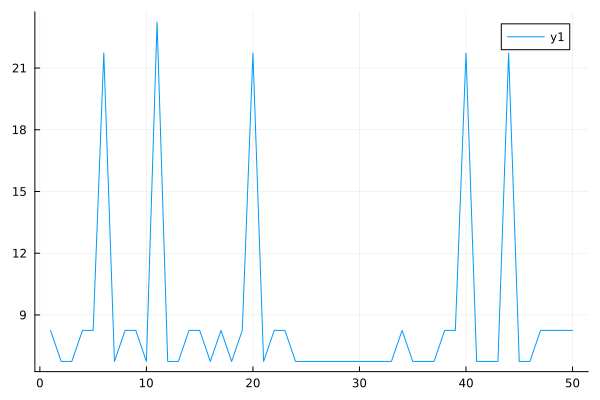

In [8]:
plot(1:50, accuracy)

In [15]:
accuracy = zeros(5)
accuracy_list = zeros(50)
for j in 1:length(accuracy_list)
    for i in 1:length(accuracy)
        accuracy[i] = range_accuracy([1,2^i])
    end
    accuracy_list[j] = mean(accuracy)
    accuracy = zeros(5)
end

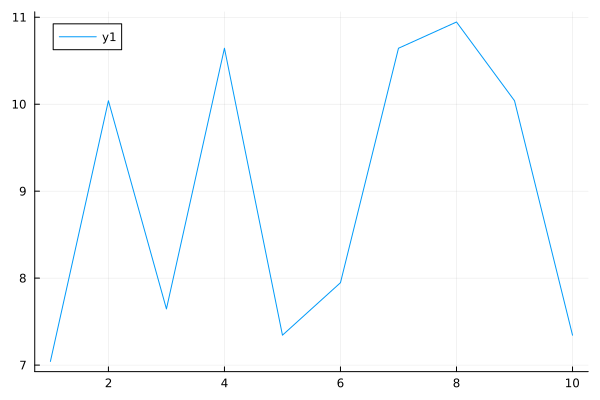

In [14]:
plot(1:10, accuracy_list)

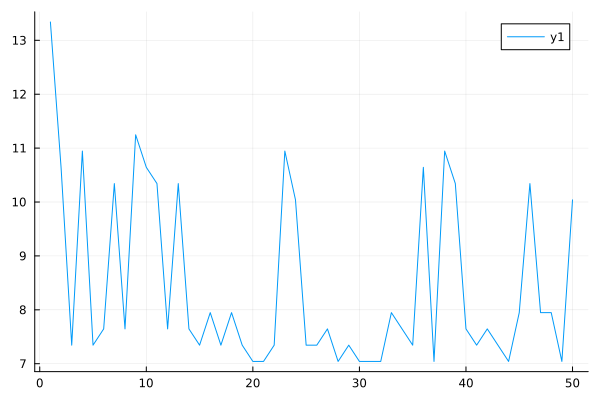

In [16]:
plot(1:50, accuracy_list)

In [145]:
function sidelobe_performance(coeff)
    samp_rate = 10e6  #hz
    prf = 100 #Hz
    duty_factor = .15; #.05
    β = 1e6; #Pulse Bandwidth
    repetitions = 128;
    fc = 900_000_000; #Hz
    Gt = 40; #dB
    Gr = 45; #dB
    system_loss = 6; #dB
    coefficients = [1];
    targets = [Target(560_094, 0)]
    num_targets = length(targets);
    target_dist = 560_094;
    τ = duty_factor * (1/prf);
    λ = (1/fc) * c;
    t, pulse_train = gen_pulse_train(repetitions, samp_rate, prf, τ, β, envelope_type="Rectangular", pulse_type="NOrderPoly", coefficients=coeff);
    rx_pulse_train, noise = sim_return(samp_rate, pulse_train, targets, fc=fc, system_loss=system_loss, Gt=Gt, Gr=Gr, SNR=-70);
    null, p = single_pulse(samp_rate, prf, τ, β, envelope_type="Rectangular", pulse_type="NOrderPoly", coefficients=coeff);
    pulse_compression = conv(rx_pulse_train, conj(reverse(p[begin:round(Int, τ*samp_rate)])));
    pulse_compression = pulse_compression[length(p)-1:length(rx_pulse_train)-(length(p)-1)];

    sigPower = abs.(pulse_compression);
    sigPowerdB = 10*log10.(real.(pulse_compression).^2 .+ imag.(pulse_compression).^2);
    sigPower = sigPower[1:26500*2];
    peaks = argmaxima(sigPower);
    null, sigPowerMaxPeakIdx = findmax(sigPower);
    peaksPeakIdx = first(findall(x->x==sigPowerMaxPeakIdx, peaks));
    sigPowerSidelobeIdx = peaks[peaksPeakIdx+1];
    sidelobePerformance = sigPowerdB[sigPowerMaxPeakIdx] - sigPowerdB[sigPowerSidelobeIdx];
    return sidelobePerformance
end

sidelobe_performance([1])

13.337925478173027

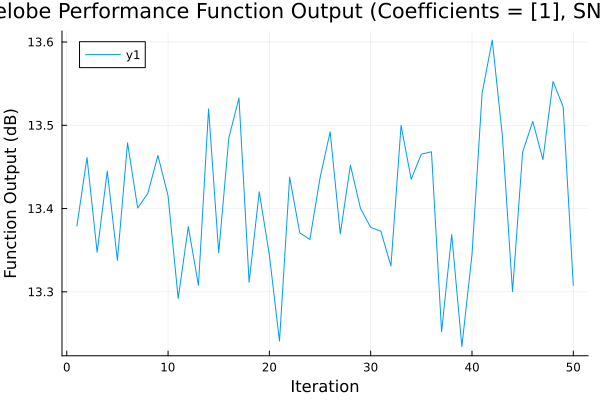

In [147]:
sidelobe_perf = zeros(50)
for i in 1:length(sidelobe_perf)
    sidelobe_perf[i] = sidelobe_performance([1])
end
plot(1:length(sidelobe_perf), sidelobe_perf, xguide="Iteration", yguide="Function Output (dB)", title="Sidelobe Performance Function Output (Coefficients = [1], SNR = -70)")

In [150]:
sidelobe_perf2 = zeros(1)
sidelobe_perf_list = zeros(100)
for j in 1:length(sidelobe_perf_list)
    for i in 1:length(sidelobe_perf2)
        sidelobe_perf2[i] = sidelobe_performance([1,20^i])
    end
    sidelobe_perf_list[j] = mean(sidelobe_perf2)
    sidelobe_perf2 = zeros(1)
end


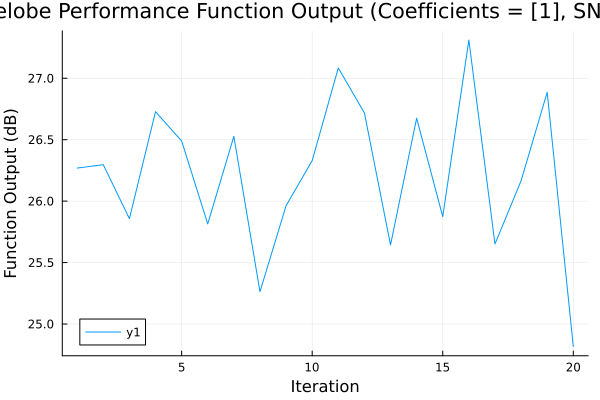

In [149]:
plot(1:length(sidelobe_perf_list), sidelobe_perf_list, xguide="Iteration", yguide="Function Output (dB)", title="Sidelobe Performance Function Output (Coefficients = [1], SNR = -71)")

In [ ]:
function gradient(coefficients)
    Δ = 1e-6;
    gradient = zeros(length(coefficients));
    for i in 1:length(coefficients)
        coefficients_perturbed = copy(coefficients);
        coefficients_perturbed[i] += Δ;
        cost_plus = sidelobe_performance(coefficients_perturbed);
        coefficients_perturbed[i] -= 2Δ;
        cost_minus = sidelobe_performance(coefficients_perturbed);
        gradient[i] = (cost_plus - cost_minus) / (2Δ);
    end
    return gradient
end

function gradient_descent(cost_fn, gradient_fn, initial_x, learning_rate, num_iterations)
    current_x = initial_x;
    Δ = 1e-8;
    grad_sq = zeros(length(current_x));
    for i in 1:num_iterations
        gradient = gradient_fn(current_x);
        grad_sq .+= gradient.^2;
        adaptive_lr = learning_rate ./ (sqrt.(grad_sq) .+ Δ);
        current_x += adaptive_lr .* gradient;
        current_cost = cost_fn(current_x);
        println("Iteration $i: Cost = $current_cost")
        print(current_x)
    end
    return current_x
end

In [ ]:
initial_coefficients = [1.0,2.0];
learning_rate = 0.01;
num_iterations = 10;

optimal_coefficients = gradient_descent(sidelobe_performance, gradient, initial_coefficients, learning_rate, num_iterations)

### Range Doppler Plot

In [ ]:
len = Int(1/prf * samp_rate);
range_stacked = reshape(pulse_compression, len, repetitions);

In [ ]:
range_doppler = fft((range_stacked), (2,));

In [ ]:
maxRange = ((1/prf * c)/2)
maxDop = (prf*λ)/4;

rangeLabel = LinRange(0, maxRange , 13);
dopplerLabel = LinRange(-maxDop,maxDop,13);

rangeLabel = round.(Int, (rangeLabel ./ 1000));
dopplerLabel = round.(dopplerLabel, digits=2);

In [ ]:
heatmap(20*log10.(abs.(range_doppler)), xlabel="Doppler (m/s)", ylabel="Range (km)", xticks=(LinRange(0,repetitions, 13), dopplerLabel), yticks=(LinRange(1,len,13), rangeLabel))

### Theoretical Ambiguouity Function

In [ ]:
v = 0:(maxDop * 4);

r = ((c^2)/(8*fc)) ./ v;

In [ ]:
plot(v,r./1000, labels="Ambiguouity Function", xlabel="Maximum unambiguous Velocity (m/s)", ylabel="Maximum unambiguous Range (km)")